# Modeling: try PCR method with RF
* Try modeling with pca with random forest

## Import packages

In [1]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression, PLSSVD

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn import preprocessing, svm
from sklearn.metrics import r2_score, accuracy_score, mean_absolute_error

#Use to ignore convergence warnings
import warnings
from sklearn.exceptions import DataConversionWarning
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import __version__ as sklearn_version
import datetime

import joblib

warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=FitFailedWarning)


# pd.set_option('display.max_columns', None)
# pd.reset_option('max_rows')
# np.set_printoptions(threshold=sys.maxsize)

plt.style.use('dark_background')
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
sns.set(style='ticks', context='talk')

## Load X and y data sets

In [2]:
# import X and y training and test sets

X = pd.read_csv('../../data/train_test/X_alt')
y = pd.read_csv('../../data/train_test/y_alt')

X_train = pd.read_csv('../../data/train_test/X_train_74_26')

X_test = pd.read_csv('../../data/train_test/X_test_74_26')

y_train = pd.read_csv('../../data/train_test/y_train_alt_74_26')

y_test = pd.read_csv('../../data/train_test/y_test_alt+74_26')

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.26, random_state=42)


In [11]:
pcr_pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA()), ('rf', RandomForestRegressor(random_state=42))])

In [5]:
num_components = [int(n) for n in np.logspace(start=1, stop=7, num=10, base=2)]
num_components

[2, 3, 5, 8, 12, 20, 32, 50, 80, 128]

In [12]:
pcr_param_grid = {'pca__n_components':np.arange(1,46)}

In [13]:
pcr_grid = GridSearchCV(pcr_pipe, pcr_param_grid, cv=5)
pcr_grid.fit(X_train, y_train)
pcr_grid.best_params_, pcr_grid.best_score_

({'pca__n_components': 40}, 0.1363217980389594)

In [14]:
pcr_best = pcr_grid.best_estimator_
pcr_mean_score = pcr_grid.cv_results_['mean_test_score']
pcr_std_score = pcr_grid.cv_results_['std_test_score']

num_comp_vals = [n for n in pcr_grid.cv_results_['param_pca__n_components']]
num_comp_best = pcr_best.get_params()['pca__n_components']

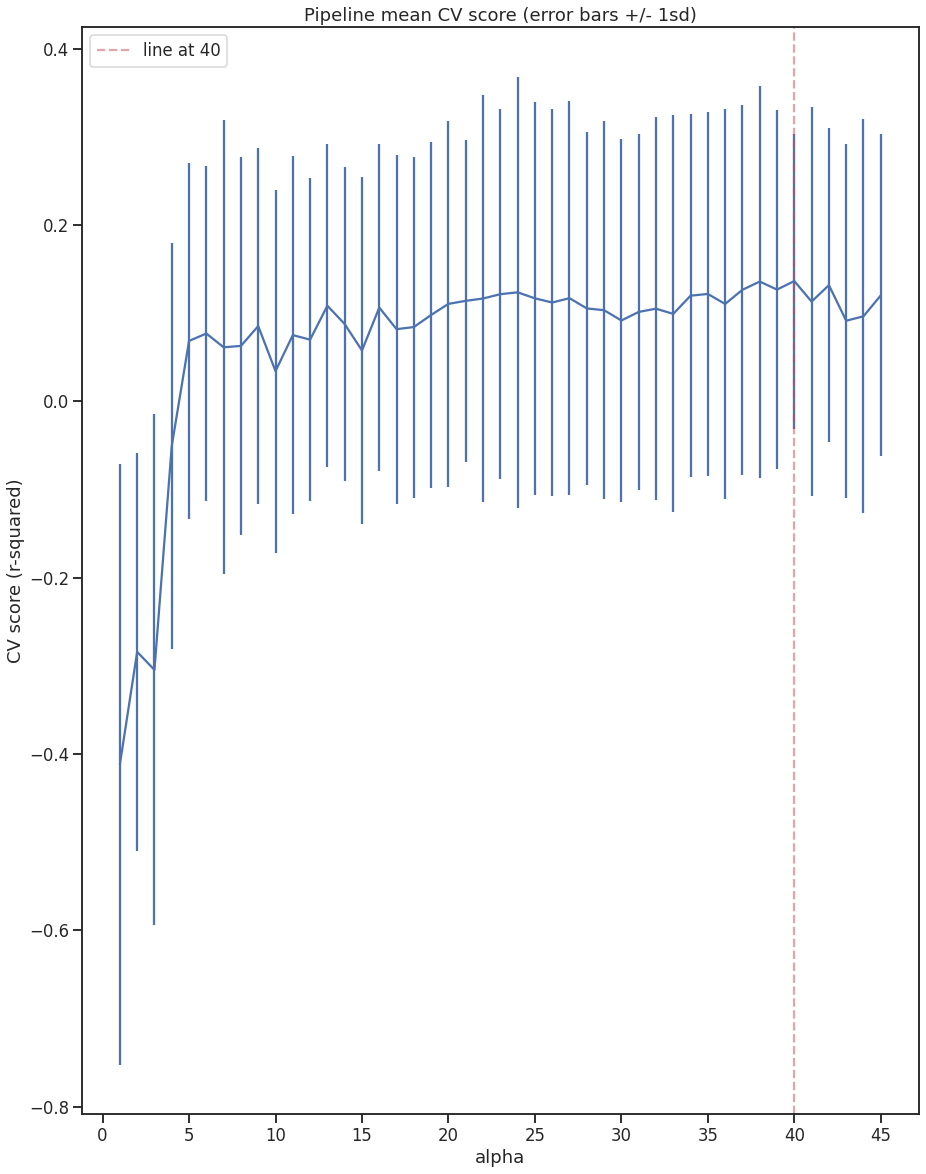

In [16]:
plt.figure(figsize=(15,20))
plt.errorbar(num_comp_vals, pcr_mean_score, yerr=pcr_std_score)
plt.axvline(x=num_comp_best, c='r', ls='--', alpha=.5, label='line at {}'.format(num_comp_best))
plt.xticks(np.arange(0,50, step=5))
plt.xlabel('num of comps')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)')
plt.legend();

# eval
it appears that after 5 components the score starts to stay around the same

## Try tuning estimators along with pca (maybe remove scaler and see if any improvment)

In [18]:
pcr_pipe.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('pca', PCA()),
  ('rf', RandomForestRegressor(random_state=42))],
 'verbose': False,
 'scaler': StandardScaler(),
 'pca': PCA(),
 'rf': RandomForestRegressor(random_state=42),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': None,
 'pca__random_state': None,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__criterion': 'mse',
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_impurity_split': None,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 100,
 'rf__n_jobs': None,
 'rf__oob_score': False,
 'rf__random_state': 42,
 'rf__verbose': 0,
 'rf__warm_start': False}

In [23]:

pcr_param_grid_2 = {'pca__n_components':np.arange(40, 100)}

In [24]:
pcr_grid_2 = GridSearchCV(pcr_pipe, pcr_param_grid_2, cv=5)
pcr_grid_2.fit(X_train, y_train)
pcr_grid_2.best_params_, pcr_grid.best_score_

({'pca__n_components': 57}, 0.1363217980389594)

In [25]:
pcr_best = pcr_grid_2.best_estimator_
pcr_mean_score = pcr_grid_2.cv_results_['mean_test_score']
pcr_std_score = pcr_grid_2.cv_results_['std_test_score']

num_comp_vals = [n for n in pcr_grid_2.cv_results_['param_pca__n_components']]
num_comp_best = pcr_best.get_params()['pca__n_components']

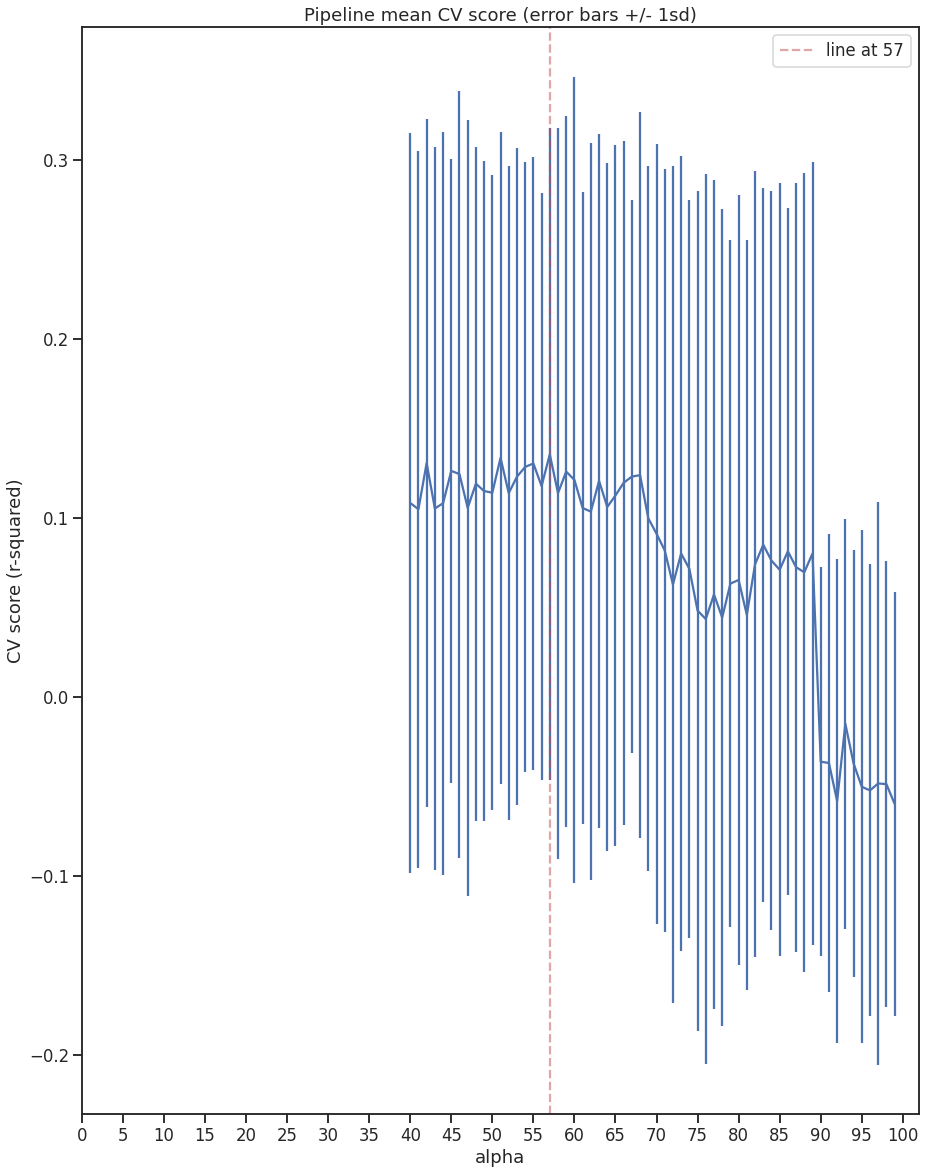

In [27]:
plt.figure(figsize=(15,20))
plt.errorbar(num_comp_vals, pcr_mean_score, yerr=pcr_std_score)
plt.axvline(x=num_comp_best, c='r', ls='--', alpha=.5, label='line at {}'.format(num_comp_best))
plt.xticks(np.arange(0,105, step=5))
plt.xlabel('num of comps')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)')
plt.legend();

## eval
It appears that after 65 components we appear to dip in score. Also values from 40 to 60 components
appear to yeild relatively similar mean cv scores


## try working with estimators for hyperameters as well

In [34]:
pcr_pipe.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('pca', PCA()),
  ('rf', RandomForestRegressor(random_state=42))],
 'verbose': False,
 'scaler': StandardScaler(),
 'pca': PCA(),
 'rf': RandomForestRegressor(random_state=42),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': None,
 'pca__random_state': None,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__criterion': 'mse',
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_impurity_split': None,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 100,
 'rf__n_jobs': None,
 'rf__oob_score': False,
 'rf__random_state': 42,
 'rf__verbose': 0,
 'rf__warm_start': False}

In [49]:
n_est = [int(n) for n in np.logspace(start=1, stop=8, num=20, base=2)]

pcr_param_grid_3 = {'pca__n_components':np.arange(10, 60),
                    'rf__criterion':['mae','mse'],
                    'rf__n_estimators':n_est}

In [59]:
pcr_grid_3 = RandomizedSearchCV(pcr_pipe, pcr_param_grid_3, cv=5)
pcr_grid_3.fit(X_train, y_train)
pcr_grid_3.best_params_, pcr_grid.best_score_

KeyboardInterrupt: 

In [55]:
pcr_best = pcr_grid_3.best_estimator_
pcr_mean_score = pcr_grid_3.cv_results_['mean_test_score']
pcr_std_score = pcr_grid_3.cv_results_['std_test_score']

num_comp_vals = [n for n in pcr_grid_3.cv_results_['param_pca__n_components']]
num_est_vals = [n for n in pcr_grid_3.cv_results_['param_rf__n_estimators']]

num_comp_best = pcr_best.get_params()['pca__n_components']
n_est_best = pcr_best.get_params()['rf__n_estimators']

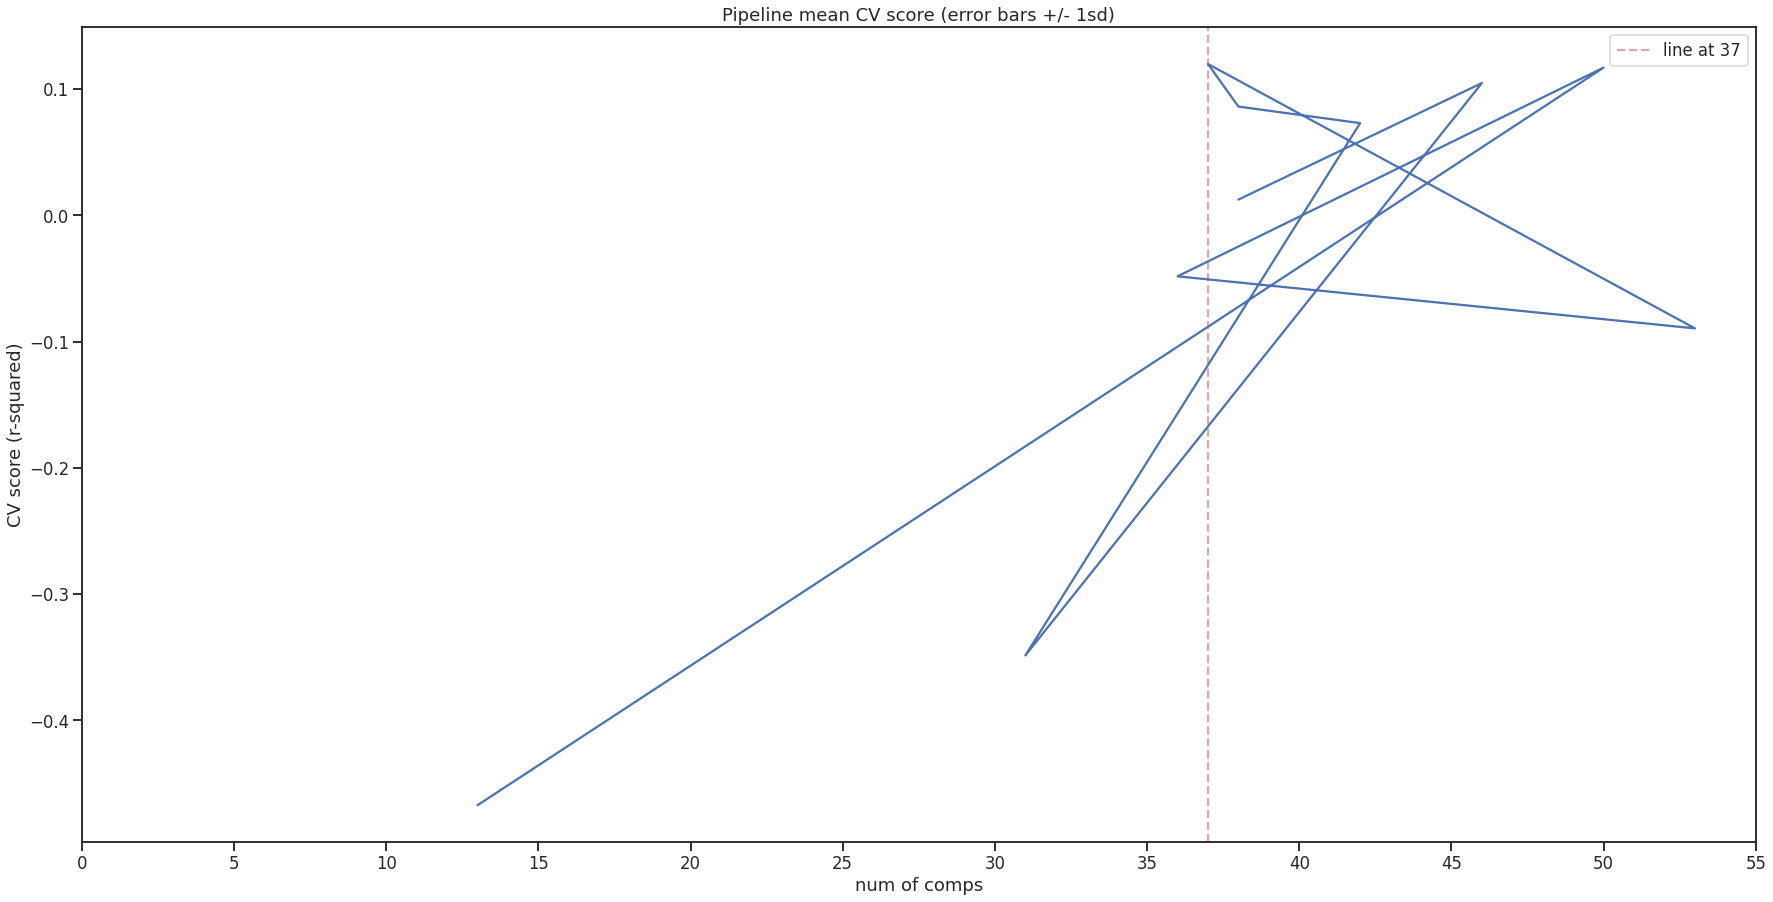

In [46]:
plt.figure(figsize=(30,15))
plt.errorbar(num_comp_vals, pcr_mean_score, )
plt.axvline(x=num_comp_best, c='r', ls='--', alpha=.5, label='line at {}'.format(num_comp_best))
plt.xticks(np.arange(0,60, step=5))
plt.xlabel('num of comps')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)')
plt.legend();

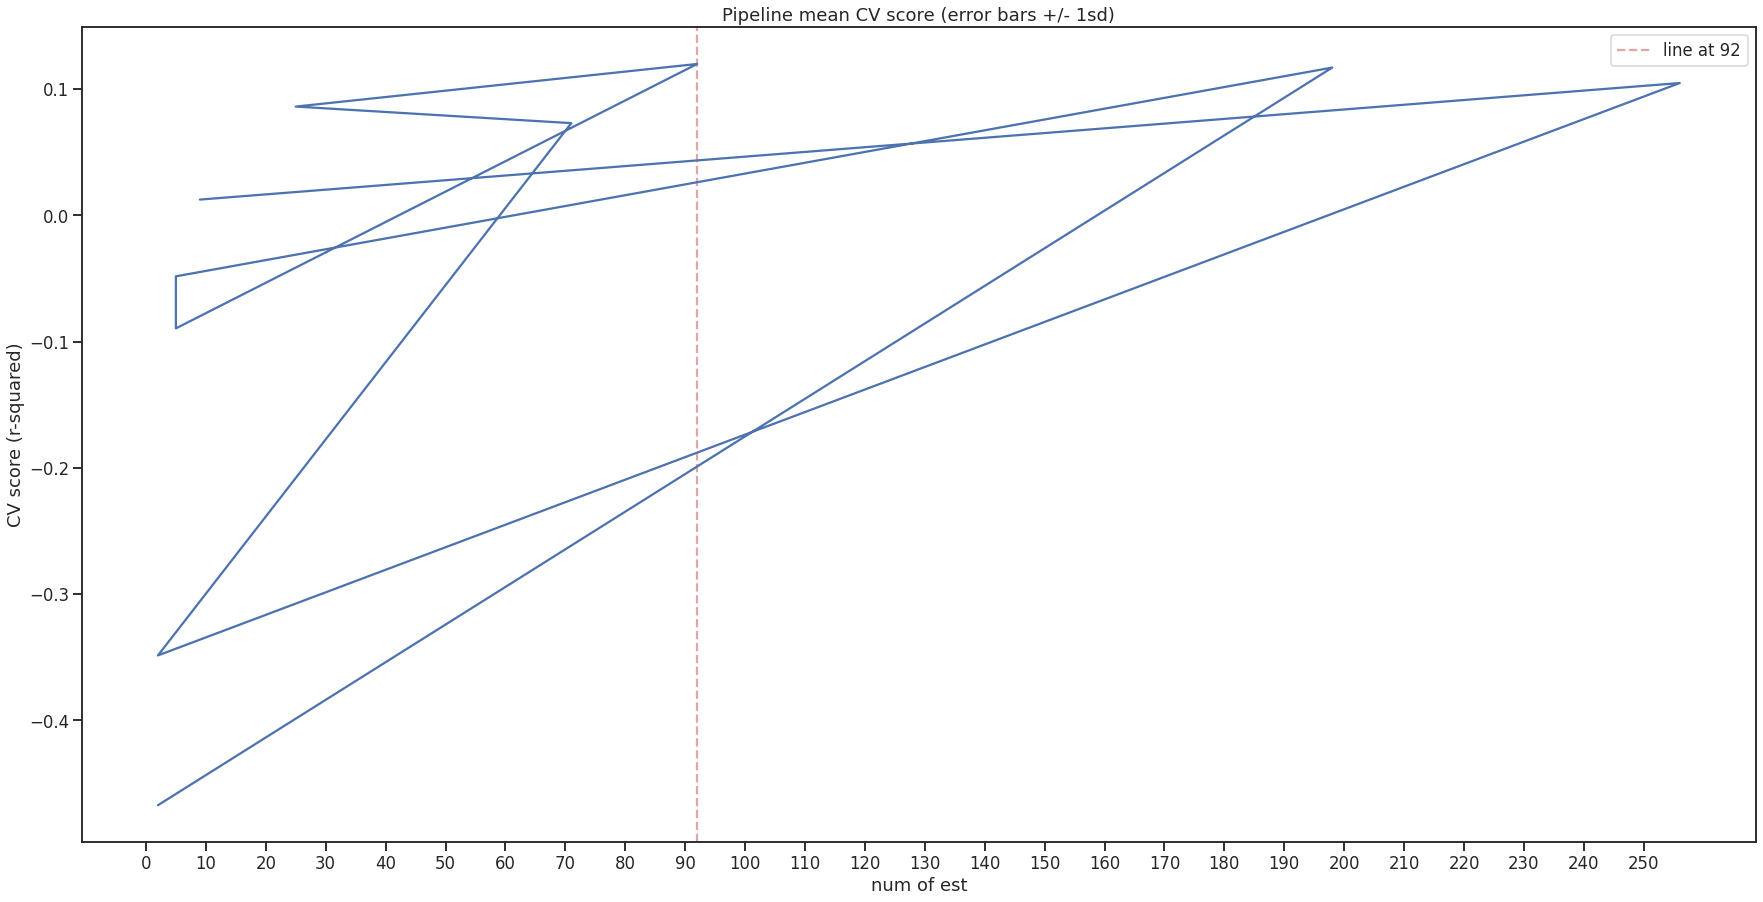

In [58]:
plt.figure(figsize=(30,15))
plt.errorbar(num_est_vals, pcr_mean_score)
plt.axvline(x=n_est_best, c='r', ls='--', alpha=.5, label='line at {}'.format(n_est_best))
plt.xticks(np.arange(0,260, step=10))
plt.xlabel('num of est')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)')
plt.legend();

do grid

In [61]:
n_est = [int(n) for n in np.logspace(start=1, stop=8, num=20, base=2)]

pcr_param_grid_3 = {'pca__n_components':np.arange(20, 50),
                    'rf__criterion':['mae','mse'],
                    'rf__n_estimators':np.arange(20, 200)}

In [62]:
pcr_grid_3 = RandomizedSearchCV(pcr_pipe, pcr_param_grid_3, cv=5)
pcr_grid_3.fit(X_train, y_train)
pcr_grid_3.best_params_, pcr_grid.best_score_

({'rf__n_estimators': 181, 'rf__criterion': 'mae', 'pca__n_components': 23},
 0.1363217980389594)

In [63]:
pcr_best = pcr_grid_3.best_estimator_
pcr_mean_score = pcr_grid_3.cv_results_['mean_test_score']
pcr_std_score = pcr_grid_3.cv_results_['std_test_score']

num_comp_vals = [n for n in pcr_grid_3.cv_results_['param_pca__n_components']]
num_est_vals = [n for n in pcr_grid_3.cv_results_['param_rf__n_estimators']]

num_comp_best = pcr_best.get_params()['pca__n_components']
n_est_best = pcr_best.get_params()['rf__n_estimators']

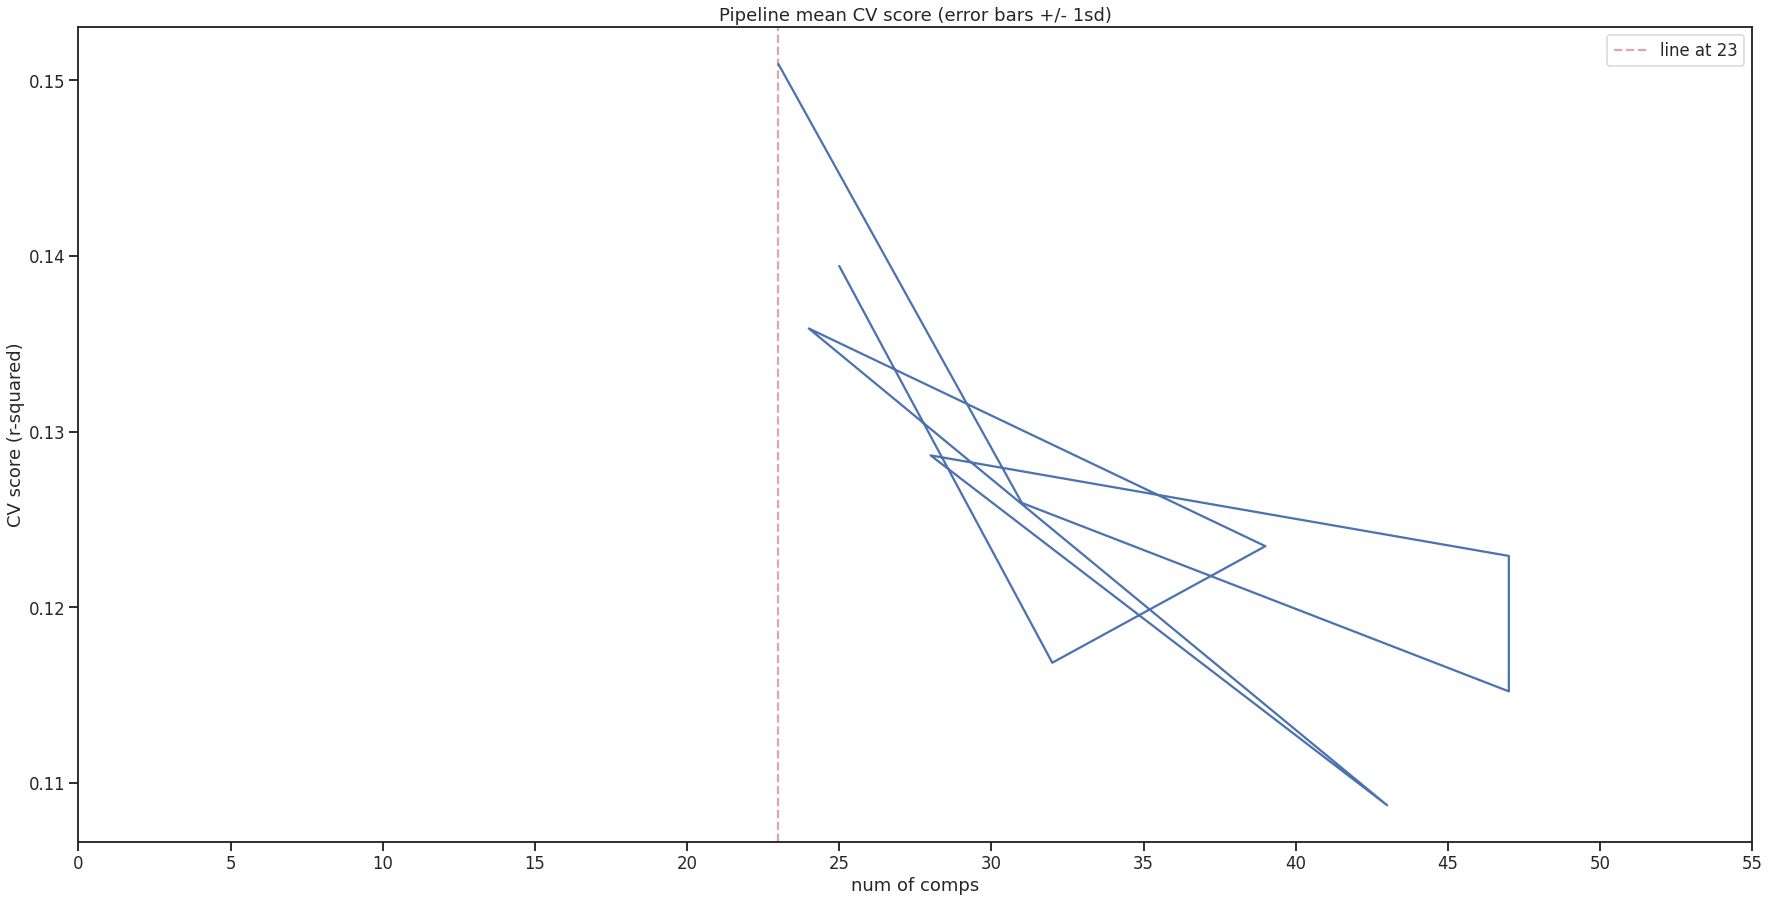

In [64]:
plt.figure(figsize=(30,15))
plt.errorbar(num_comp_vals, pcr_mean_score, )
plt.axvline(x=num_comp_best, c='r', ls='--', alpha=.5, label='line at {}'.format(num_comp_best))
plt.xticks(np.arange(0,60, step=5))
plt.xlabel('num of comps')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)')
plt.legend();

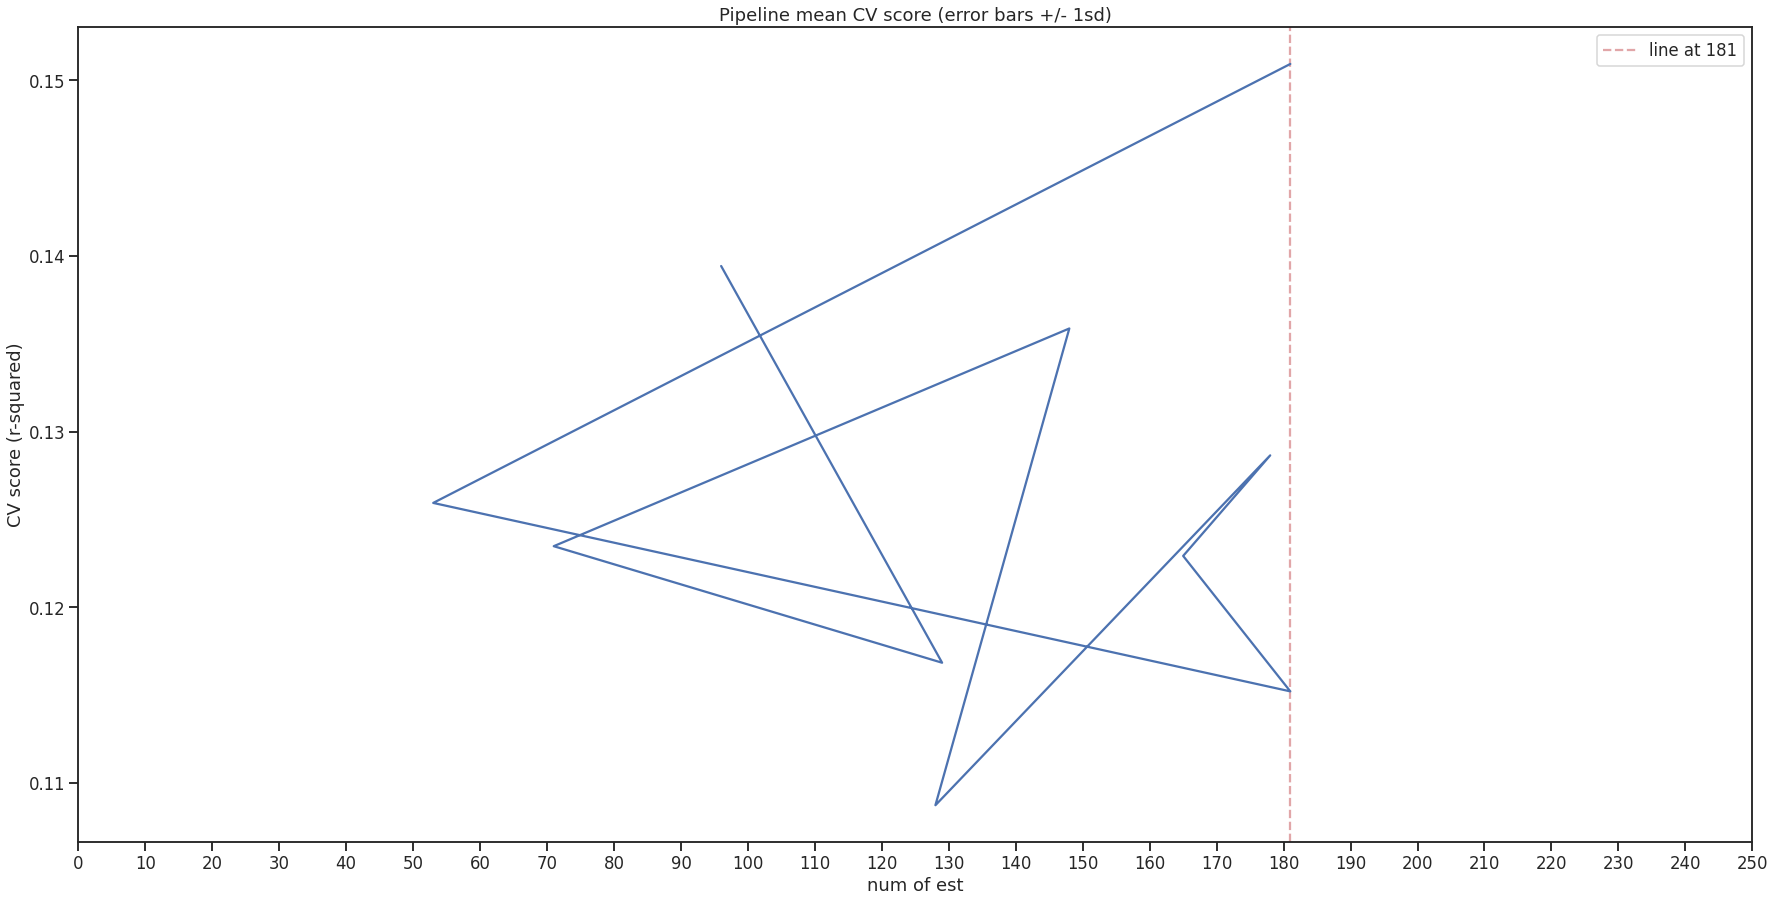

In [65]:
plt.figure(figsize=(30,15))
plt.errorbar(num_est_vals, pcr_mean_score)
plt.axvline(x=n_est_best, c='r', ls='--', alpha=.5, label='line at {}'.format(n_est_best))
plt.xticks(np.arange(0,260, step=10))
plt.xlabel('num of est')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)')
plt.legend();

With PCR random forest our train score cannot exceed .2 which means it does not generalize well to our training data